In [1]:
!pip install alpha_vantage
!pip install xgboost
!pip install pandas_ta==0.3.14b0
!pip install optuna 
!pip install --upgrade pyspark==3.3.0 delta-spark==2.2.0
!pip install --upgrade numpy
!pip install --upgrade pandas_ta
!pip install matplotlib



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import typing
import io
import pandas as pd
import numpy as np
np.NaN = np.nan 
import pandas_ta as ta
import optuna
import logging
from datetime import timedelta
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
import os
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt

os.environ['JAVA_HOME'] = '/opt/homebrew/opt/openjdk@11'
os.environ['PATH'] = '/opt/homebrew/opt/openjdk@11/bin:' + os.environ['PATH']

/Users/chielg/Documents/GitHub/BDA/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


add more data visualizations and insights

            1. open   2. high  3. low  4. close   5. volume
date                                                       
2025-05-16   520.66  521.7000  517.10    521.51  48394603.0
2025-05-15   516.52  521.9300  515.17    519.25  50153275.0
2025-05-14   516.77  519.2279  515.75    518.68  47014516.0
2025-05-13   509.16  517.3900  508.42    515.59  53269573.0
2025-05-12   506.99  507.8900  501.48    507.85  45090616.0


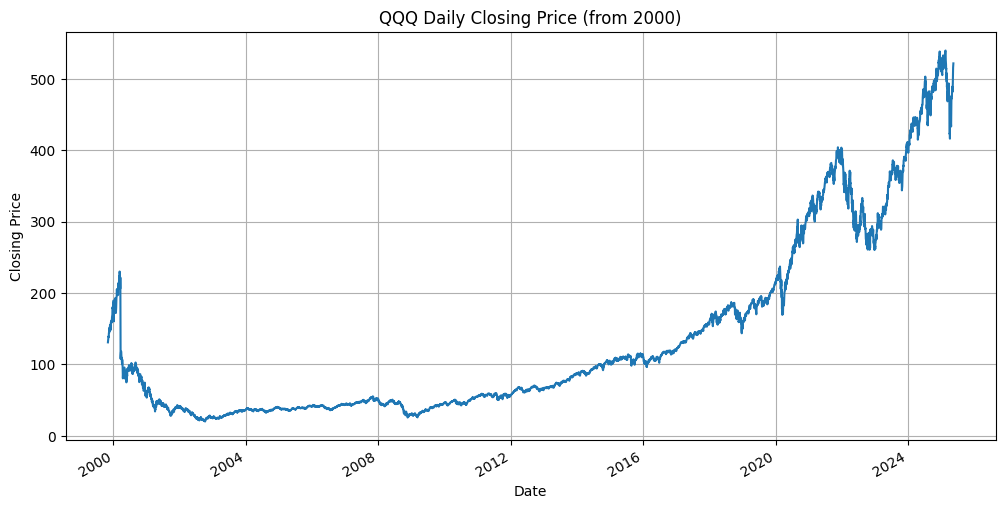

In [22]:
api_key = 'PH8UF085L5T5MFZN'
symbol = 'QQQ'  # S&P 500 Index

ts = TimeSeries(key=api_key, output_format='pandas')
data, meta_data = ts.get_daily(symbol=symbol, outputsize='full')

data.index = pd.to_datetime(data.index)
data = data[data.index >= '1900-01-01']

print(data.head())

data['4. close'].plot(figsize=(12, 6), title=f'{symbol} Daily Closing Price (from 2000)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()


In [23]:
# Ensure the column names are correct
data.columns = ['open', 'high', 'low', 'close', 'volume']

In [24]:
data

,open,high,low,close,volume
date,,,,,
2025-05-16,520.66,521.7000,517.10,521.51,48394603.0
2025-05-15,516.52,521.9300,515.17,519.25,50153275.0
2025-05-14,516.77,519.2279,515.75,518.68,47014516.0
2025-05-13,509.16,517.3900,508.42,515.59,53269573.0
2025-05-12,506.99,507.8900,501.48,507.85,45090616.0
...,...,...,...,...,...
1999-11-05,137.80,138.4000,136.40,136.40,7567300.0
1999-11-04,135.40,135.6000,133.60,135.00,10024300.0
1999-11-03,132.80,134.3000,132.40,133.50,9376300.0


In [25]:
data

,open,high,low,close,volume
date,,,,,
2025-05-16,520.66,521.7000,517.10,521.51,48394603.0
2025-05-15,516.52,521.9300,515.17,519.25,50153275.0
2025-05-14,516.77,519.2279,515.75,518.68,47014516.0
2025-05-13,509.16,517.3900,508.42,515.59,53269573.0
2025-05-12,506.99,507.8900,501.48,507.85,45090616.0
...,...,...,...,...,...
1999-11-05,137.80,138.4000,136.40,136.40,7567300.0
1999-11-04,135.40,135.6000,133.60,135.00,10024300.0
1999-11-03,132.80,134.3000,132.40,133.50,9376300.0


In [26]:
stockdata = data


stockdata

,open,high,low,close,volume
date,,,,,
2025-05-16,520.66,521.7000,517.10,521.51,48394603.0
2025-05-15,516.52,521.9300,515.17,519.25,50153275.0
2025-05-14,516.77,519.2279,515.75,518.68,47014516.0
2025-05-13,509.16,517.3900,508.42,515.59,53269573.0
2025-05-12,506.99,507.8900,501.48,507.85,45090616.0
...,...,...,...,...,...
1999-11-05,137.80,138.4000,136.40,136.40,7567300.0
1999-11-04,135.40,135.6000,133.60,135.00,10024300.0
1999-11-03,132.80,134.3000,132.40,133.50,9376300.0


In [27]:
# ================= TREND INDICATORS =================
stockdata.ta.sma(length=100, append=True)               # Simple Moving Average (SMA) - Average price over a period
stockdata.ta.ema(length=20, append=True)               # Exponential Moving Average (EMA) - Weighted average favoring recent prices
stockdata.ta.wma(length=20, append=True)               # Weighted Moving Average (WMA) - Linear weights on recent prices
stockdata.ta.hma(length=20, append=True)               # Hull Moving Average (HMA) - Reduced lag, smooth trend indicator
stockdata.ta.vwma(length=20, append=True)              # Volume-Weighted Moving Average (VWMA) - Prices weighted by volume
stockdata.ta.macd(fast=12, slow=26, signal=9, append=True)  # Moving Average Convergence Divergence (MACD) - Trend momentum (MACD, MACDh, MACDs)
stockdata.ta.adx(length=14, append=True)               # Average Directional Index (ADX) - Trend strength (ADX, +DI, -DI)
stockdata.ta.cci(length=20, append=True)               # Commodity Channel Index (CCI) - Overbought/oversold levels
stockdata.ta.rsi(length=14, append=True)               # Relative Strength Index (RSI) - Momentum oscillator (0-100)
stockdata.ta.stoch(k=14, d=3, append=True)             # Stochastic Oscillator (STOCH) - Price momentum (K%, D%)
stockdata.ta.ichimoku(tenkan=9, kijun=26, senkou=52, append=True)  # Ichimoku Cloud - Support/resistance, trend, momentum (5 columns)
stockdata.ta.supertrend(length=7, multiplier=3, append=True)  # SuperTrend - Trend direction with ATR volatility (SUPERT, SUPERTd)
stockdata.ta.psar(step=0.02, max_step=0.2, append=True)  # Parabolic SAR (PSAR) - Trailing stop for trends

# ================= MOMENTUM INDICATORS =================
stockdata.ta.mom(length=50, append=True)               # Momentum (MOM) - Price change over period
stockdata.ta.roc(length=10, append=True)               # Rate of Change (ROC) - Percentage price change
stockdata.ta.willr(length=14, append=True)             # Williams %R (WILLR) - Overbought/oversold levels (-0 to -100)
stockdata.ta.uo(append=True)                           # Ultimate Oscillator (UO) - Multi-timeframe momentum
stockdata.ta.ao(fast=5, slow=34, append=True)          # Awesome Oscillator (AO) - Momentum based on 34/5 EMAs
stockdata.ta.kama(length=10, append=True)              # Kaufman's Adaptive MA (KAMA) - Volatility-adjusted moving average
stockdata.ta.cg(length=10, append=True)                # Center of Gravity (CG) - Price cycle indicator

# ================= VOLATILITY INDICATORS =================
stockdata.ta.bbands(length=20, std=2, append=True)     # Bollinger Bands (BBANDS) - Volatility bands (BB_U, BB_M, BB_L)
stockdata.ta.atr(length=14, append=True)               # Average True Range (ATR) - Volatility measure
stockdata.ta.kc(length=20, scalar=2, append=True)      # Keltner Channel (KC) - Volatility bands with ATR (KC_U, KC_M, KC_L)
stockdata.ta.donchian(lower_length=20, upper_length=20, append=True)  # Donchian Channel (DONCHIAN) - Price range channels
stockdata.ta.rvi(length=14, append=True)               # Relative Volatility Index (RVI) - Standard deviation-based oscillator

# ================= VOLUME INDICATORS =================
stockdata.ta.obv(append=True)                          # On-Balance Volume (OBV) - Cumulative volume flow
stockdata.ta.cmf(length=20, append=True)               # Chaikin Money Flow (CMF) - Volume-weighted money flow
stockdata.ta.adosc(fast=3, slow=10, append=True)       # AD Oscillator (ADOSC) - Accumulation/Distribution line oscillator
stockdata.ta.mfi(length=14, append=True)               # Money Flow Index (MFI) - Volume-weighted RSI
stockdata.ta.vwap(append=True)                         # Volume-Weighted Avg Price (VWAP) - Intraday benchmark price
stockdata.ta.eom(length=14, append=True)               # Ease of Movement (EOM) - Price/volume relationship
stockdata.ta.nvi(length=255, append=True)              # Negative Volume Index (NVI) - Smart money indicator

# ================= OTHER INDICATORS =================
stockdata.ta.squeeze(append=True)                      # TTM Squeeze (SQZ) - Bollinger vs Keltner volatility
stockdata.ta.fisher(length=9, append=True)             # Fisher Transform (FISHER) - Normalize prices to Gaussian
stockdata.ta.decay(length=5, mode="linear", append=True)  # Linear/Exponential Decay (DECAY) - Synthetic smoothing
stockdata.ta.decay(length=5, mode="exponential", append=True)  # Linear/Exponential Decay (DECAY) - Synthetic smoothing
stockdata.ta.vortex(length=14, append=True)            # Vortex Indicator (VTX) - Trend reversal detection
stockdata.ta.zscore(length=20, append=True)            # Z-Score (ZSCORE) - Standard deviations from mean
stockdata.ta.entropy(length=10, append=True)           # Entropy (ENTROPY) - Measure of market randomness

[!] VWAP volume series is not datetime ordered. Results may not be as expected.
[!] VWAP price series is not datetime ordered. Results may not be as expected.


/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_61640/2380868436.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.37684148e+10 1.91458755e+10 1.45059687e+10 ... 1.42444008e+09
 1.40324021e+09 6.36578350e+08]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stockdata.ta.mfi(length=14, append=True)               # Money Flow Index (MFI) - Volume-weighted RSI
/var/folders/tc/1rlgym492m70rw7ddhrpc1_80000gn/T/ipykernel_61640/2380868436.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.60186832e+10 2.43481581e+10 2.73699066e+10 ... 1.35060735e+09
 1.25079842e+09 8.43674187e+08]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stockdata.ta.mfi(length=14, append=True)               # Money Flow Index (MFI) - Volume-weighted RS

date
2025-05-16         NaN
2025-05-15         NaN
2025-05-14         NaN
2025-05-13         NaN
2025-05-12         NaN
                ...   
1999-11-05    3.255427
1999-11-04    3.248765
1999-11-03    3.246073
1999-11-02    3.239142
1999-11-01    3.238107
Name: ENTP_10, Length: 6425, dtype: float64

after engineering move to pyspark, describe in report why

transforming (remove nulls after cuz its about loading the data in first)

In [47]:
import pandas as pd
import numpy as np

def prepare_data_for_ml(stockdata):
    # Make a copy to avoid modifying the original data
    df = stockdata.copy()

    # Calculate mean values for comparison
    atr_mean = df['ATRr_14'].mean()
    vwap_mean = df['VWAP_D'].mean()

    # Create boolean columns for each condition
    df['condition1'] = df['SMA_100'] > df['close']
    df['condition2'] = df['EMA_20'] > df['SMA_100']
    df['condition3'] = df['RSI_14'] > 50
    df['condition4'] = df['ATRr_14'] < atr_mean
    df['condition5'] = df['VWAP_D'] > vwap_mean
    df['condition6'] = df['MOM_50'] > 0

    # Count how many conditions are met (True counts as 1, False as 0)
    df['conditions_met'] = (df['condition1'].astype(int) +
                           df['condition2'].astype(int) +
                           df['condition3'].astype(int) +
                           df['condition4'].astype(int) +
                           df['condition5'].astype(int) +
                           df['condition6'].astype(int))

    # Create our label (0-6) representing how many conditions were met
    df['label'] = df['conditions_met']

    # Drop the individual condition columns if not needed
   # df = df.drop(columns=['condition1', 'condition2', 'condition3',
   #                      'condition4', 'condition5', 'condition6'])

    return df

# Apply the function to your data
final_df = prepare_data_for_ml(stockdata)

# Display the first few rows to verify
print("First 5 rows of final dataframe:")
print(final_df[['close', 'SMA_100', 'EMA_20', 'RSI_14', 'ATRr_14',
                'VWAP_D', 'MOM_50', 'conditions_met', 'label']].head())

# Print label distribution
print("\nLabel Distribution (number of conditions met):")
label_counts = final_df['label'].value_counts().sort_index()
for label, count in label_counts.items():
    print(f"{label} conditions met: {count} records ({count/len(final_df)*100:.2f}%)")

First 5 rows of final dataframe:
             close  SMA_100  EMA_20  RSI_14  ATRr_14      VWAP_D  MOM_50  \
date                                                                       
2025-05-16  521.51      NaN     NaN     NaN      NaN  520.103333     NaN   
2025-05-15  519.25      NaN     NaN     NaN      NaN  518.783333     NaN   
2025-05-14  518.68      NaN     NaN     NaN      NaN  517.885967     NaN   
2025-05-13  515.59      NaN     NaN     NaN      NaN  513.800000     NaN   
2025-05-12  507.85      NaN     NaN     NaN      NaN  505.740000     NaN   

            conditions_met  label  
date                               
2025-05-16               1      1  
2025-05-15               1      1  
2025-05-14               1      1  
2025-05-13               1      1  
2025-05-12               1      1  

Label Distribution (number of conditions met):
1 conditions met: 91 records (1.42%)
2 conditions met: 2905 records (45.21%)
3 conditions met: 2068 records (32.19%)
4 conditions met:

In [48]:
# First, let's see all columns currently in final_df to be sure
print("Current columns in final_df:")
print(final_df.columns)
print("-" * 50)

# These are the OHLCV column names we expect from earlier in your notebook
ohlcv_cols = ['open', 'high', 'low', 'close', 'volume']

# These are the condition columns
condition_cols = ['condition1', 'condition2', 'condition3', 'condition4', 'condition5', 'condition6']

# Combine them
columns_to_show = ohlcv_cols + condition_cols

try:
    # Select only these columns
    stockdata_with_binary_conditions = final_df[columns_to_show]

    # Display the first few rows
    print("\nStockdata with OHLCV and binary condition inputs (True/False):")
    print(stockdata_with_binary_conditions.head())

    # If you want to see more, uncomment one of these:
    # print(stockdata_with_binary_conditions.sample(10))
    # print(stockdata_with_binary_conditions)

except KeyError as e:
    print(f"\n--- ERROR ---")
    print(f"A KeyError occurred: {e}")
    print("This means one or more of the column names in 'columns_to_show' were NOT found in 'final_df'.")
    print("Look at the 'Current columns in final_df' printed above.")
    print("1. If 'open', 'high', etc., are named differently, correct the 'ohlcv_cols' list in THIS cell.")
    print("2. If 'condition1', 'condition2', etc., are missing, you MUST go back to Step 1 and fix 'prepare_data_for_ml'.")


Current columns in final_df:
Index(['open', 'high', 'low', 'close', 'volume', 'SMA_100', 'EMA_20', 'WMA_20',
       'HMA_20', 'VWMA_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
       'ADX_14', 'DMP_14', 'DMN_14', 'CCI_20_0.015', 'RSI_14', 'STOCHk_14_3_3',
       'STOCHd_14_3_3', 'ISA_9', 'ISB_26', 'ITS_9', 'IKS_26', 'ICS_26',
       'SUPERT_7_3.0', 'SUPERTd_7_3.0', 'SUPERTl_7_3.0', 'SUPERTs_7_3.0',
       'PSARl_0.02_0.2', 'PSARs_0.02_0.2', 'PSARaf_0.02_0.2', 'PSARr_0.02_0.2',
       'MOM_50', 'ROC_10', 'WILLR_14', 'UO_7_14_28', 'AO_5_34', 'KAMA_10_2_30',
       'CG_10', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0',
       'BBP_20_2.0', 'ATRr_14', 'KCLe_20_2.0', 'KCBe_20_2.0', 'KCUe_20_2.0',
       'DCL_20_20', 'DCM_20_20', 'DCU_20_20', 'RVI_14', 'OBV', 'CMF_20',
       'ADOSC_3_10', 'MFI_14', 'VWAP_D', 'EOM_14_100000000', 'NVI_255',
       'SQZ_20_2.0_20_1.5', 'SQZ_ON', 'SQZ_OFF', 'SQZ_NO', 'FISHERT_9_1',
       'FISHERTs_9_1', 'LDECAY_5', 'VTXP_14', 'VTXM_14', 'Z

In [49]:
pd.set_option('display.max_columns', None)
final_df

,open,high,low,close,volume,SMA_100,EMA_20,WMA_20,HMA_20,VWMA_20,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ADX_14,DMP_14,DMN_14,CCI_20_0.015,RSI_14,STOCHk_14_3_3,STOCHd_14_3_3,ISA_9,ISB_26,ITS_9,IKS_26,ICS_26,SUPERT_7_3.0,SUPERTd_7_3.0,SUPERTl_7_3.0,SUPERTs_7_3.0,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,MOM_50,ROC_10,WILLR_14,UO_7_14_28,AO_5_34,KAMA_10_2_30,CG_10,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,ATRr_14,KCLe_20_2.0,KCBe_20_2.0,KCUe_20_2.0,DCL_20_20,DCM_20_20,DCU_20_20,RVI_14,OBV,CMF_20,ADOSC_3_10,MFI_14,VWAP_D,EOM_14_100000000,NVI_255,SQZ_20_2.0_20_1.5,SQZ_ON,SQZ_OFF,SQZ_NO,FISHERT_9_1,FISHERTs_9_1,LDECAY_5,VTXP_14,VTXM_14,ZS_20,ENTP_10,condition1,condition2,condition3,condition4,condition5,condition6,conditions_met,label
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-05-16,520.66,521.7000,517.10,521.51,48394603.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,466.00,0.000000,1,NaN,NaN,NaN,NaN,0.02,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.839460e+07,NaN,NaN,NaN,520.103333,NaN,1727.909475,NaN,0,0,1,NaN,NaN,521.51,NaN,NaN,NaN,NaN,False,False,False,False,True,False,1,1
2025-05-15,516.52,521.9300,515.17,519.25,50153275.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,416.06,NaN,1,NaN,NaN,515.17,NaN,0.02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.758672e+06,NaN,NaN,NaN,518.783333,NaN,1727.909475,NaN,0,0,1,NaN,NaN,521.31,NaN,NaN,NaN,NaN,False,False,False,False,True,False,1,1
2025-05-14,516.77,519.2279,515.75,518.68,47014516.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,423.69,NaN,1,NaN,NaN,515.17,NaN,0.02,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.877319e+07,NaN,NaN,NaN,517.885967,NaN,1727.909475,NaN,0,0,1,NaN,NaN,519.05,NaN,NaN,NaN,NaN,False,False,False,False,True,False,1,1
2025-05-13,509.16,517.3900,508.42,515.59,53269573.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,422.67,NaN,1,NaN,NaN,NaN,521.930000,0.02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.020428e+08,NaN,NaN,NaN,513.800000,NaN,1727.909475,NaN,0,0,1,NaN,NaN,518.48,NaN,NaN,NaN,NaN,False,False,False,False,True,False,1,1
2025-05-12,506.99,507.8900,501.48,507.85,45090616.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,450.66,NaN,1,NaN,NaN,NaN,521.659800,0.04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.471334e+08,NaN,NaN,NaN,505.740000,NaN,1727.909475,NaN,0,0,1,NaN,NaN,515.39,NaN,NaN,NaN,NaN,False,False,False,False,True,False,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999-11-05,137.80,138.4000,136.40,136.40,7567300.0,175.8892,147.667407,144.645714,138.400606,148.014544,-7.101435,-0.351348,-6.750086,47.427294,6.905818,28.284320,-132.675647,27.926439,6.187031,9.625364,171.775,185.45,142.40,149.55,NaN,150.463884,-1,NaN,150.463884,NaN,142.296423,0.20,0,-55.6,-10.026385,-100.000000,51.628177,-15.582794,143.999067,-5.581659,135.499185,147.695,159.890815,16.514865,0.036931,5.235881,138.048932,147.667407,157.285882,136.4,148.4,160.4,31.022754,-1.824707e+10,0.083558,6.966101e+06,15.349667,137.066667,-59.961068,1119.532871,-11.766667,0,1,0,-6.079555,-4.558707,138.90,0.541284,1.116208,-1.805374,3.255427,True,False,False,False,True,False,2,2
1999-11-04,135.40,135.6000,133.60,135.00,10024300.0,176.1392,146.460987,143.436667,136.793688,146.698941,-7.251556,-0.401175,-6.850380,48.672434,6.632962,31.117874,-143.666790,26.794889,6.425968,7.600010,171.420,185.45,141.00,147.30,NaN,1

Store CSV's in delta lake parquet

In [31]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

stockdata.describe()



,open,high,low,close,volume,SMA_100,EMA_20,WMA_20,HMA_20,VWMA_20,...,SQZ_ON,SQZ_OFF,SQZ_NO,FISHERT_9_1,FISHERTs_9_1,LDECAY_5,VTXP_14,VTXM_14,ZS_20,ENTP_10
count,6425.000000,6425.000000,6425.000000,6425.000000,6.425000e+03,6326.000000,6406.000000,6406.000000,6403.000000,6406.000000,...,6425.000000,6425.000000,6425.000000,6417.000000,6416.000000,6425.000000,6411.000000,6411.000000,6406.000000,6407.000000
mean,134.843826,135.933989,133.631424,134.852738,6.807202e+07,131.870793,134.323757,134.139335,133.691018,133.936841,...,0.251829,0.745058,0.003113,-0.404047,-0.402940,135.517207,0.769485,0.841419,-0.311878,3.319975
std,127.607103,128.531011,126.586182,127.637669,1.445308e+08,124.261747,126.954781,126.729544,126.279076,126.567299,...,0.434097,0.435862,0.055710,1.855860,1.853886,128.316672,0.151233,0.140024,1.272289,0.038937
min,19.940000,20.530000,19.760000,20.060000,4.022600e+06,23.603200,21.787992,21.237810,19.816085,21.285193,...,0.000000,0.000000,0.000000,-7.588611,-7.588611,20.160000,0.305215,0.383791,-3.536433,3.127607
25%,42.300000,42.800000,41.890000,42.340000,3.165542e+07,41.609187,42.186196,42.168381,42.318124,42.117742,...,0.000000,0.000000,0.000000,-1.621766,-1.621764,42.480000,0.660762,0.737952,-1.358324,3.298480
50%,76.200000,76.940000,75.540000,76.490000,5.397530e+07,73.393855,76.277189,76.108250,75.505260,76.000305,...,0.000000,1.000000,0.000000,-0.381661,-0.380534,76.710000,0.768507,0.846040,-0.434841,3.315025
75%,180.680000,182.330000,179.200000,180.800000,8.733820e+07,175.009000,181.231820,180.747631,179.257748,179.955347,...,1.000000,1.000000,0.000000,0.909454,0.909966,182.020000,0.883049,0.945533,0.723565,3.335959
max,539.730000,540.810000,536.460000,539.520000,1.097837e+10,513.159800,523.910248,527.664619,544.562734,526.271277,...,1.000000,1.000000,1.000000,6.894304,6.894304,539.520000,1.285732,1.359097,4.048055,3.840178


In [32]:

stockdata_df = final_df.sort_index(ascending=True)

train_size = int(0.6 * len(stockdata_df))
test_size = len(stockdata_df) - train_size 

train_data = stockdata_df.iloc[:train_size]   
test_data = stockdata_df.iloc[train_size:]    

train_data.to_csv("train.csv", index=True) 
test_data.to_csv("test.csv", index=True)   

print("Training data saved to train.csv")
print("Testing data saved to test.csv")



Training data saved to train.csv
Testing data saved to test.csv


In [33]:
print("Number of NaN values per column in train_data:")
print(train_data.isnull().sum())

Number of NaN values per column in train_data:
open              0
high              0
low               0
close             0
volume            0
                 ..
VTXM_14           0
ZS_20             0
ENTP_10           0
conditions_met    0
label             0
Length: 73, dtype: int64


In [34]:
spark = SparkSession.builder.appName("StockDataProcessing").getOrCreate()

removing rows or mean imputation without a rolling window is not smart because of the timeseries nature of stocks, it would ruin indications of growing or shrinking trends in price


In [35]:
import pandas as pd

def fill_nan_with_rolling_median(df, window_size=21): # Use an odd window size to center
    if window_size % 2 == 0:
        window_size += 1
    if window_size < 3:
        window_size = 3

    center_offset = (window_size - 1) // 2
    df_filled = df.apply(lambda col: col.fillna(col.rolling(window=window_size, center=True).median()))


    df_filled = df_filled.fillna(df_filled.median())

    return df_filled

train_data_filled = fill_nan_with_rolling_median(train_data.copy(), window_size=21)
test_data_filled = fill_nan_with_rolling_median(test_data.copy(), window_size=21)

print("NaN counts in train_data_filled after rolling median imputation:")
print(train_data_filled.isnull().sum())

print("\nNaN counts in test_data_filled after rolling median imputation:")
print(test_data_filled.isnull().sum())

train_data_filled.to_csv("train_filled.csv", index=True)
test_data_filled.to_csv("test_filled.csv", index=True)

train_spark_df = spark.read.csv("train_filled.csv", header=True, inferSchema=True)
test_spark_df = spark.read.csv("test_filled.csv", header=True, inferSchema=True)

train_spark_df.printSchema()
test_spark_df.printSchema()

train_spark_df.show(5)
test_spark_df.show(5)

NaN counts in train_data_filled after rolling median imputation:
open              0
high              0
low               0
close             0
volume            0
                 ..
VTXM_14           0
ZS_20             0
ENTP_10           0
conditions_met    0
label             0
Length: 73, dtype: int64

NaN counts in test_data_filled after rolling median imputation:
open              0
high              0
low               0
close             0
volume            0
                 ..
VTXM_14           0
ZS_20             0
ENTP_10           0
conditions_met    0
label             0
Length: 73, dtype: int64
root
 |-- date: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- SMA_100: double (nullable = true)
 |-- EMA_20: double (nullable = true)
 |-- WMA_20: double (nullable = true)
 |-- HMA_20: double (nullable = true)
 

move from SKLEARN to pysparkML

In [36]:
train_spark_df.printSchema()
test_spark_df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- SMA_100: double (nullable = true)
 |-- EMA_20: double (nullable = true)
 |-- WMA_20: double (nullable = true)
 |-- HMA_20: double (nullable = true)
 |-- VWMA_20: double (nullable = true)
 |-- MACD_12_26_9: double (nullable = true)
 |-- MACDh_12_26_9: double (nullable = true)
 |-- MACDs_12_26_9: double (nullable = true)
 |-- ADX_14: double (nullable = true)
 |-- DMP_14: double (nullable = true)
 |-- DMN_14: double (nullable = true)
 |-- CCI_20_0.015: double (nullable = true)
 |-- RSI_14: double (nullable = true)
 |-- STOCHk_14_3_3: double (nullable = true)
 |-- STOCHd_14_3_3: double (nullable = true)
 |-- ISA_9: double (nullable = true)
 |-- ISB_26: double (nullable = true)
 |-- ITS_9: double (nullable = true)
 |-- IKS_26: double (nullable = true)
 |-- ICS_26:

In [37]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Create a mapping of old column names to new, period-free names
column_mapping = {
    'CCI_20_0.015': 'CCI_20_0_015',
    'STOCHk_14_3_3': 'STOCHk_14_3_3',
    'STOCHd_14_3_3': 'STOCHd_14_3_3',
    'SUPERT_7_3.0': 'SUPERT_7_3_0',
    'SUPERTd_7_3.0': 'SUPERTd_7_3_0',
    'SUPERTl_7_3.0': 'SUPERTl_7_3_0',
    'SUPERTs_7_3.0': 'SUPERTs_7_3_0',
    'PSARl_0.02_0.2': 'PSARl_0_02_0_2',
    'PSARs_0.02_0.2': 'PSARs_0_02_0_2',
    'PSARaf_0.02_0.2': 'PSARaf_0_02_0_2',
    'PSARr_0.02_0.2': 'PSARr_0_02_0_2',
    'UO_7_14_28': 'UO_7_14_28',
    'KAMA_10_2_30': 'KAMA_10_2_30',
    'BBL_20_2.0': 'BBL_20_2_0',
    'BBM_20_2.0': 'BBM_20_2_0',
    'BBU_20_2.0': 'BBU_20_2_0',
    'BBB_20_2.0': 'BBB_20_2_0',
    'BBP_20_2.0': 'BBP_20_2_0',
    'KCLe_20_2.0': 'KCLe_20_2_0',
    'KCBe_20_2.0': 'KCBe_20_2_0',
    'KCUe_20_2.0': 'KCUe_20_2_0',
    'DCL_20_20': 'DCL_20_20',
    'DCM_20_20': 'DCM_20_20',
    'DCU_20_20': 'DCU_20_20',
    'ADOSC_3_10': 'ADOSC_3_10',
    'EOM_14_100000000': 'EOM_14_100000000',
    'SQZ_20_2.0_20_1.5': 'SQZ_20_2_0_20_1_5',
    'FISHERT_9_1': 'FISHERT_9_1',
    'FISHERTs_9_1': 'FISHERTs_9_1'
}

for old_name, new_name in column_mapping.items():
    train_spark_df = train_spark_df.withColumnRenamed(old_name, new_name)
    test_spark_df = test_spark_df.withColumnRenamed(old_name, new_name)

feature_columns_new = [
    'open', 'high', 'low', 'close', 'volume', 'SMA_100', 'EMA_20', 'WMA_20', 'HMA_20',
    'VWMA_20', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'DMP_14',
    'DMN_14', 'CCI_20_0_015', 'RSI_14', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'ISA_9',
    'ISB_26', 'ITS_9', 'IKS_26', 'ICS_26', 'SUPERT_7_3_0', 'SUPERTd_7_3_0',
    'SUPERTl_7_3_0', 'SUPERTs_7_3_0', 'PSARl_0_02_0_2', 'PSARs_0_02_0_2',
    'PSARaf_0_02_0_2', 'PSARr_0_02_0_2', 'MOM_50', 'ROC_10', 'WILLR_14', 'UO_7_14_28',
    'AO_5_34', 'KAMA_10_2_30', 'CG_10', 'BBL_20_2_0', 'BBM_20_2_0', 'BBU_20_2_0',
    'BBB_20_2_0', 'BBP_20_2_0', 'ATRr_14', 'KCLe_20_2_0', 'KCBe_20_2_0', 'KCUe_20_2_0',
    'DCL_20_20', 'DCM_20_20', 'DCU_20_20', 'RVI_14', 'OBV', 'CMF_20', 'ADOSC_3_10',
    'MFI_14', 'VWAP_D', 'EOM_14_100000000', 'NVI_255', 'SQZ_20_2_0_20_1_5',
    'SQZ_ON', 'SQZ_OFF', 'SQZ_NO', 'FISHERT_9_1', 'FISHERTs_9_1', 'LDECAY_5', 'VTXP_14',
    'VTXM_14', 'ZS_20', 'ENTP_10'
]

assembler = VectorAssembler(inputCols=feature_columns_new, outputCol="features")

train_assembled = assembler.transform(train_spark_df)
test_assembled = assembler.transform(test_spark_df)

train_data_mllib = train_assembled.select("features", "label")
test_data_mllib = test_assembled.select("features", "label")

print("Transformed training data with feature vector (after renaming columns):")
train_data_mllib.show(5)

print("\nTransformed testing data with feature vector (after renaming columns):")
test_data_mllib.show(5)

Transformed training data with feature vector (after renaming columns):
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[131.5,133.1,130....|    1|
|[131.5,133.1,130....|    1|
|[132.8,134.3,132....|    1|
|[135.4,135.6,133....|    1|
|[137.8,138.4,136....|    2|
+--------------------+-----+
only showing top 5 rows


Transformed testing data with feature vector (after renaming columns):
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[108.61,109.42,10...|    3|
|[109.05,109.16,10...|    3|
|[108.51,108.67,10...|    3|
|[108.73,108.965,1...|    2|
|[108.5,108.71,107...|    3|
+--------------------+-----+
only showing top 5 rows



In [38]:
from pyspark.ml.classification import RandomForestClassifier

rf_classifier_mllib = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=200,            
    maxDepth=10,            
    minInstancesPerNode=5,   
    minInfoGain=0.0,         
    maxBins=32,              
    impurity='gini',         
    featureSubsetStrategy='sqrt', 
    seed=42,
    cacheNodeIds=True,
    checkpointInterval=10
)

# Train the model
rf_model_mllib = rf_classifier_mllib.fit(train_data_mllib)  



25/05/19 13:01:41 WARN DAGScheduler: Broadcasting large task binary with size 1036.2 KiB
25/05/19 13:01:41 WARN DAGScheduler: Broadcasting large task binary with size 1062.1 KiB


25/05/19 13:01:43 WARN DAGScheduler: Broadcasting large task binary with size 1191.4 KiB
25/05/19 13:01:44 WARN DAGScheduler: Broadcasting large task binary with size 1117.6 KiB


25/05/19 13:01:45 WARN DAGScheduler: Broadcasting large task binary with size 1251.6 KiB
25/05/19 13:01:46 WARN DAGScheduler: Broadcasting large task binary with size 1029.9 KiB


In [39]:
import pyspark.sql.functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


predictions = rf_model_mllib.transform(test_data_mllib)

results = predictions.select(
    F.col("label").cast("double"),
    F.col("prediction").cast("double")
)

print(f"Total test samples: {results.count()}")

print("\nClass distribution in test set:")
results.groupBy("label").count().orderBy("label").show()

print("Class distribution in predictions:")
results.groupBy("prediction").count().orderBy("prediction").show()

print("\nConfusion matrix (label vs. prediction):")
results.groupBy("label", "prediction").count().orderBy("label", "prediction").show(20)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(results, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(results, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(results, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(results, {evaluator.metricName: "weightedRecall"})

print(f"\nWalk-forward Accuracy: {accuracy:.4f}")
print(f"Walk-forward F1 Score: {f1:.4f}")
print(f"Walk-forward Weighted Precision: {precision:.4f}")
print(f"Walk-forward Weighted Recall: {recall:.4f}")

print("\nSample predictions (true label, predicted label):")
results.show(1500)

Total test samples: 2570

Class distribution in test set:
+-----+-----+
|label|count|
+-----+-----+
|  1.0|   41|
|  2.0| 1116|
|  3.0|  928|
|  4.0|  467|
|  5.0|   18|
+-----+-----+

Class distribution in predictions:
25/05/19 13:01:48 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
25/05/19 13:01:48 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
+----------+-----+
|prediction|count|
+----------+-----+
|       2.0| 1488|
|       3.0|  586|
|       4.0|  496|
+----------+-----+


Confusion matrix (label vs. prediction):
25/05/19 13:01:48 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
25/05/19 13:01:49 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       2.0|   36|
|  1.0|       3.0|    5|
|  2.0|       2.0| 1034|
|  2.0|       3.0|   58|
|  2.0|       4.0|   24|
|  3.0|       2.0|  398|
|  3.0|       3.0|  372|
|  3.0|   

In [40]:
print(f"\nWalk-forward Accuracy: {accuracy:.4f}")
print(f"Walk-forward F1 Score: {f1:.4f}")
print(f"Walk-forward Weighted Precision: {precision:.4f}")
print(f"Walk-forward Weighted Recall: {recall:.4f}")


Walk-forward Accuracy: 0.6654
Walk-forward F1 Score: 0.6370
Walk-forward Weighted Precision: 0.6423
Walk-forward Weighted Recall: 0.6654
